C:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


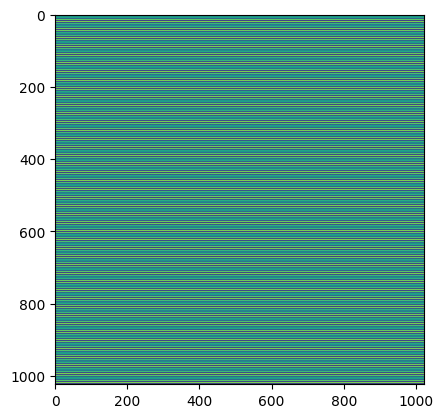

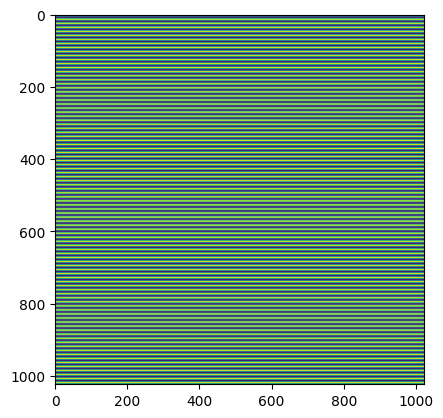

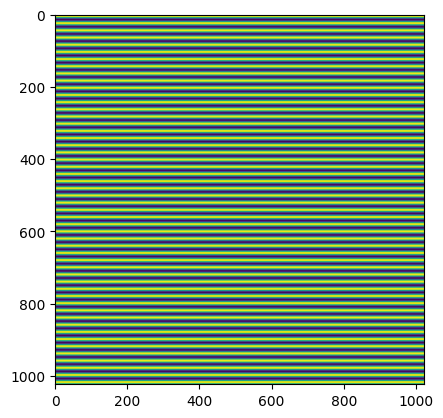

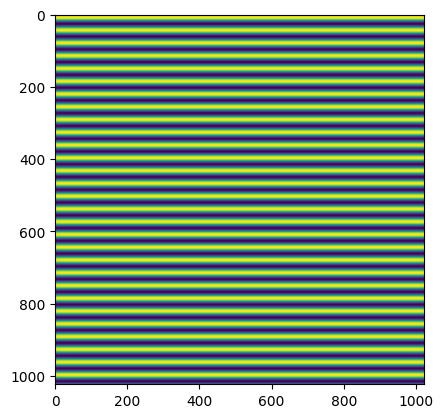

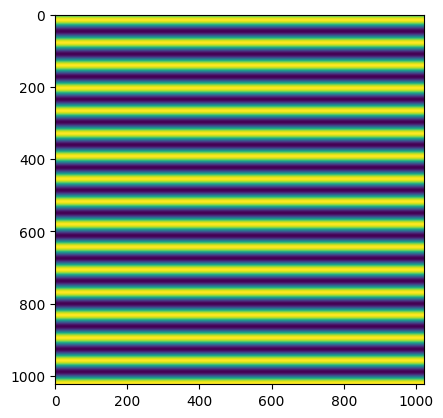

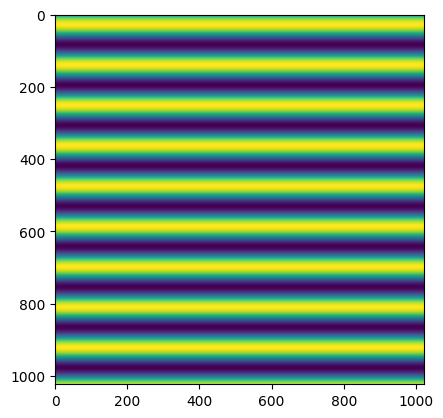

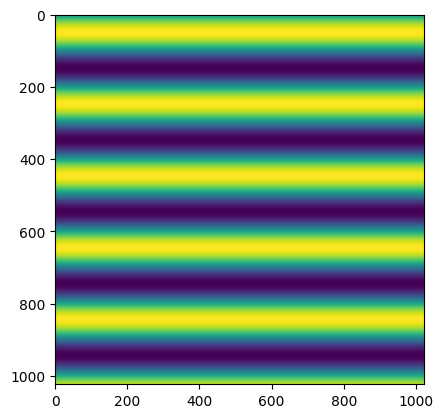

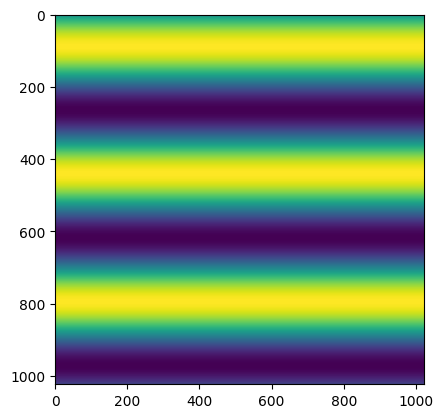

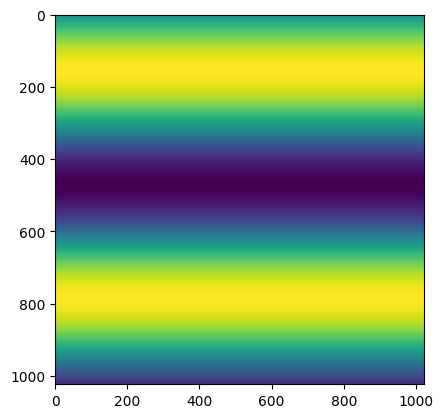

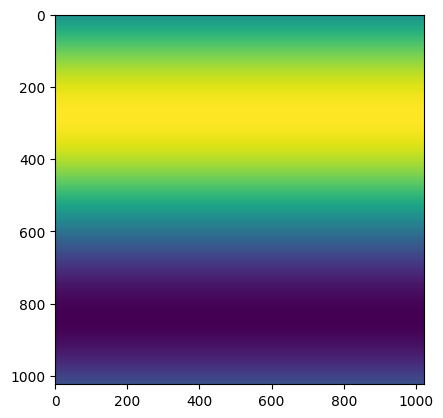

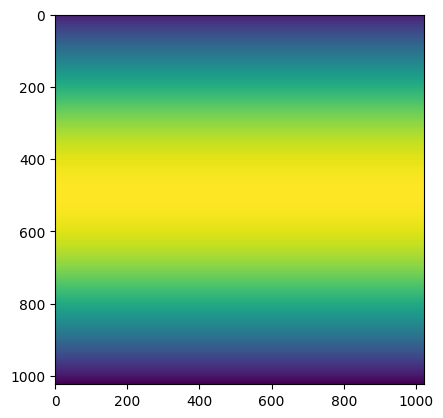

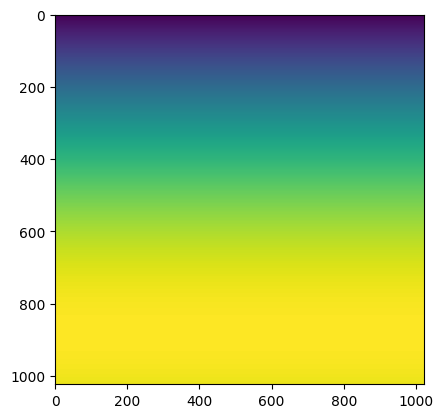

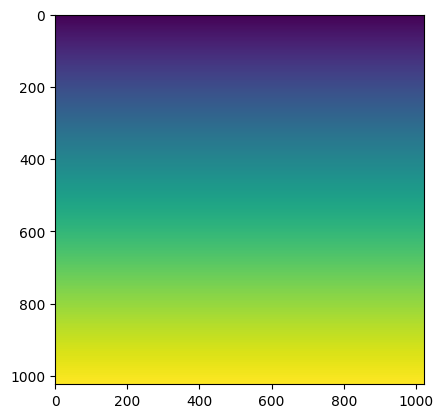

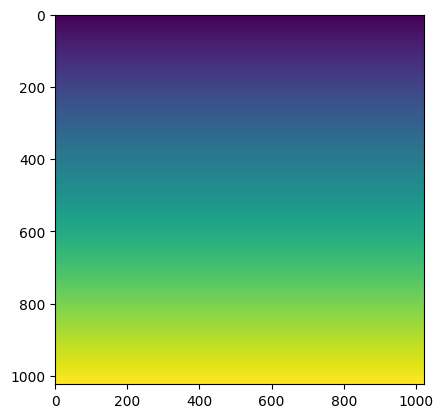

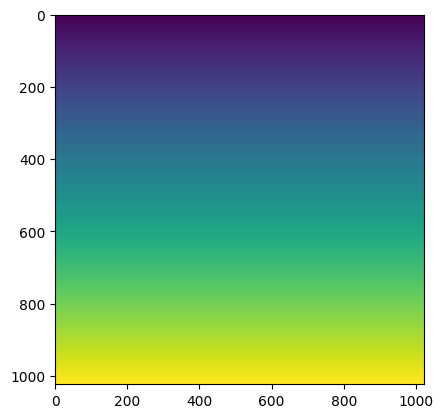

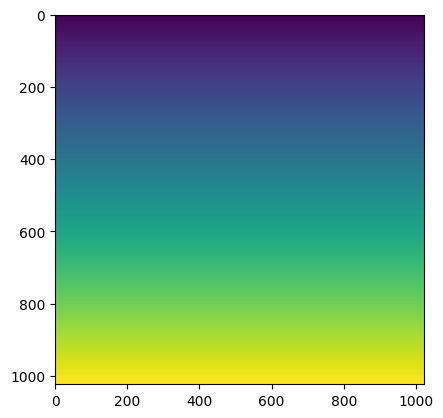

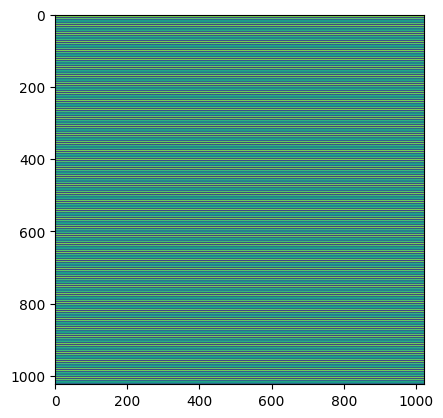

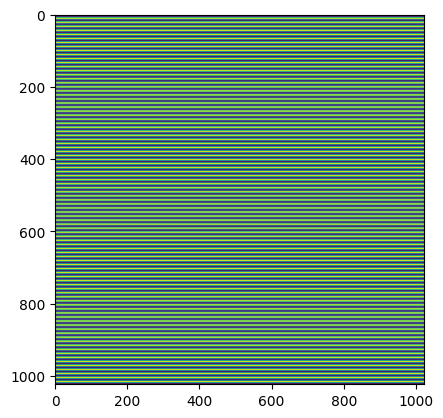

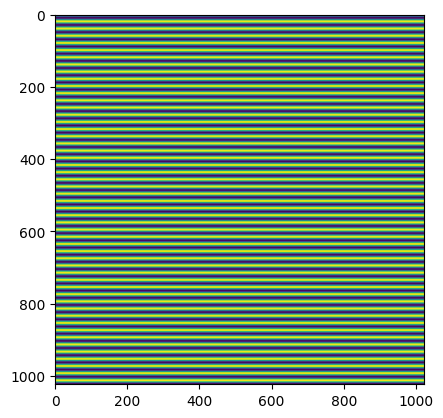

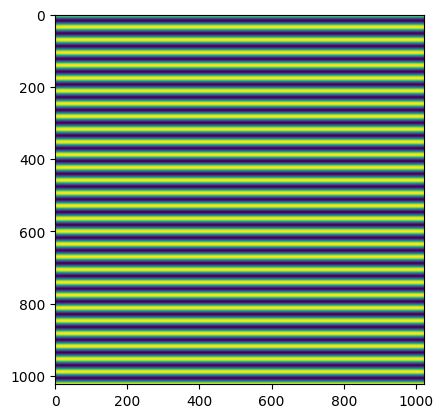

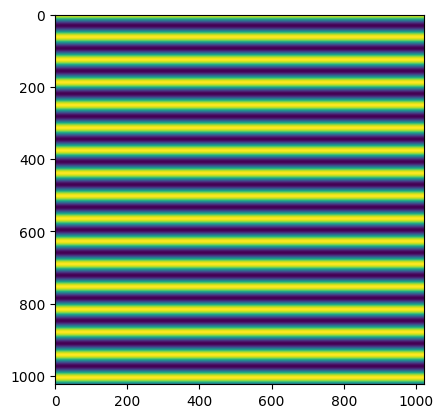

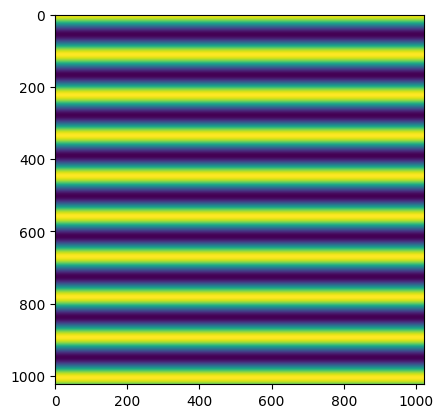

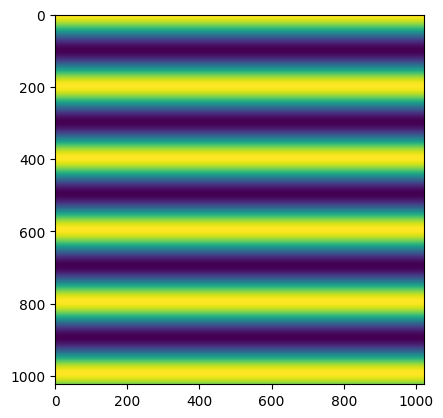

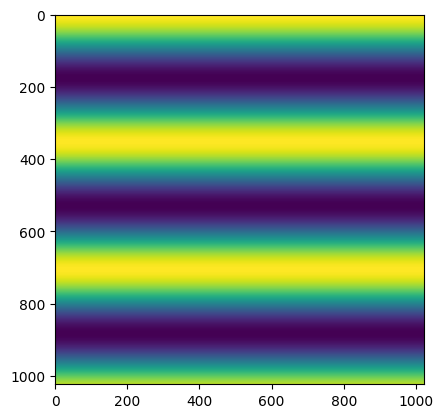

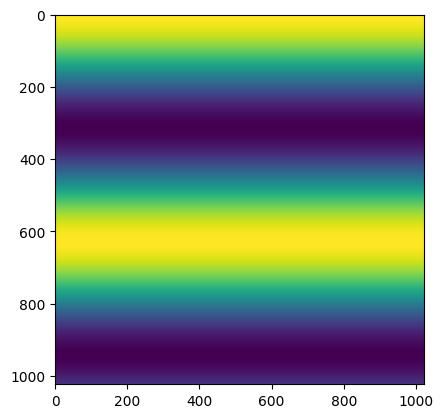

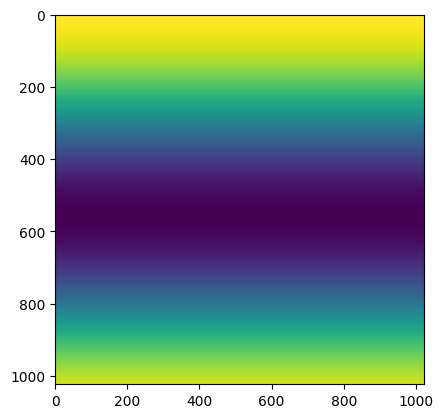

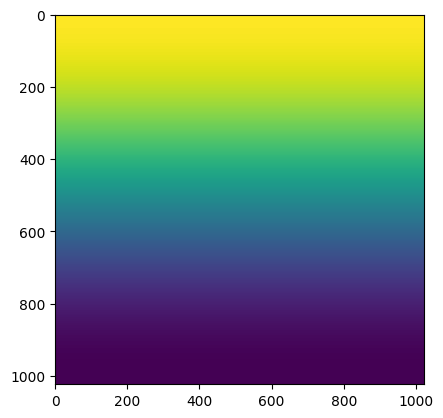

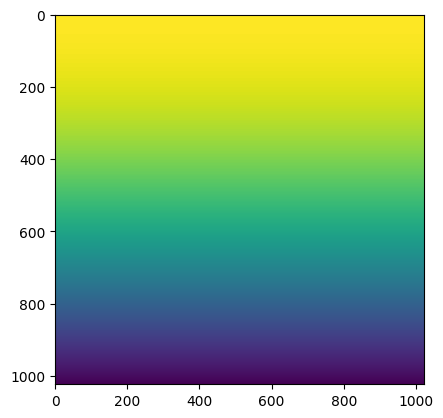

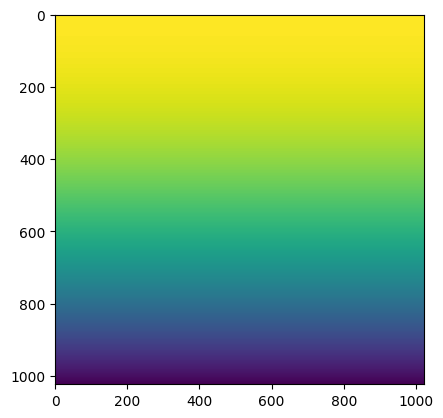

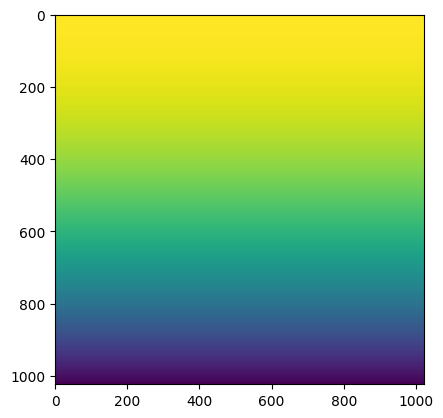

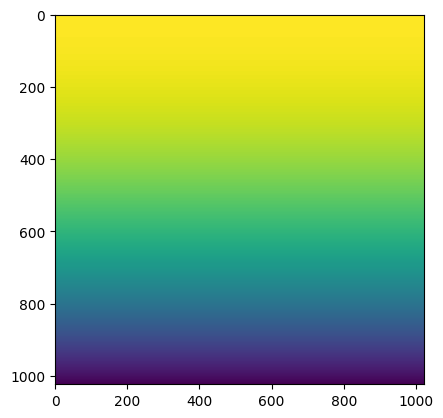

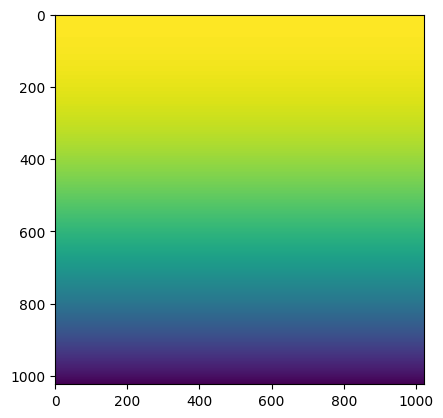

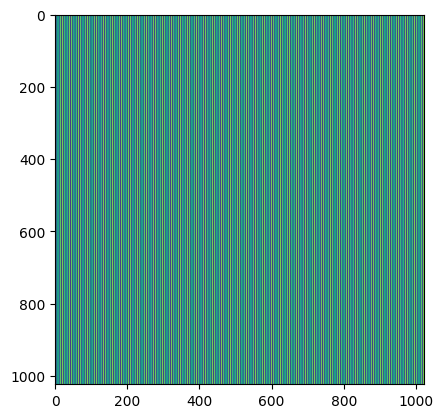

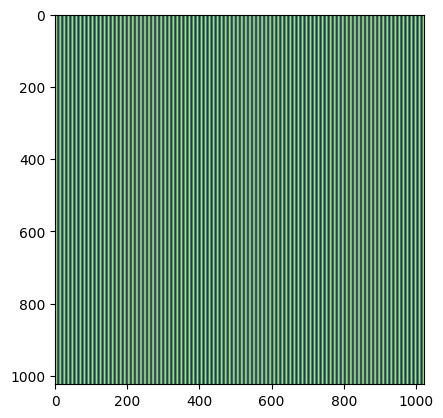

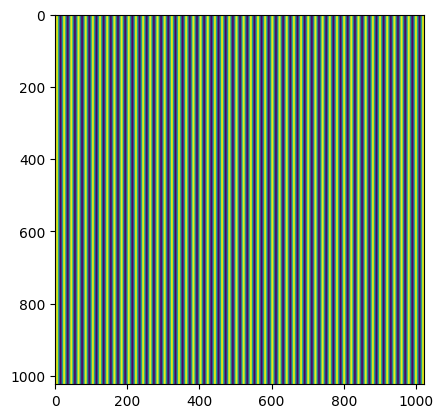

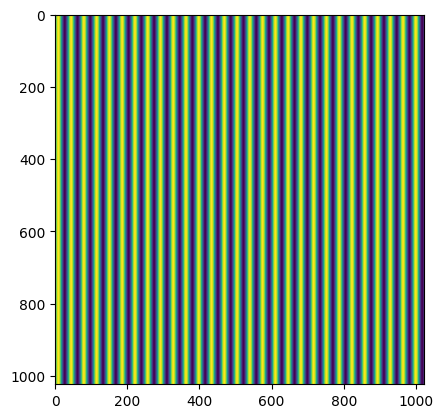

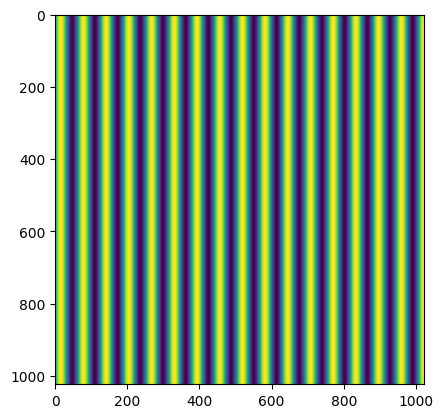

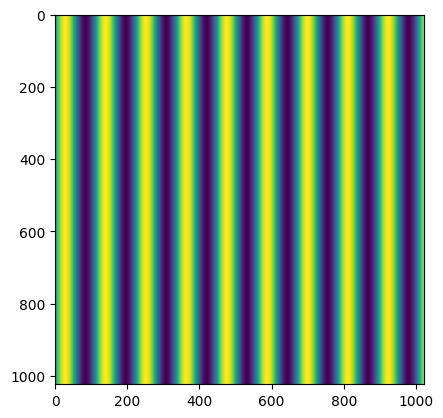

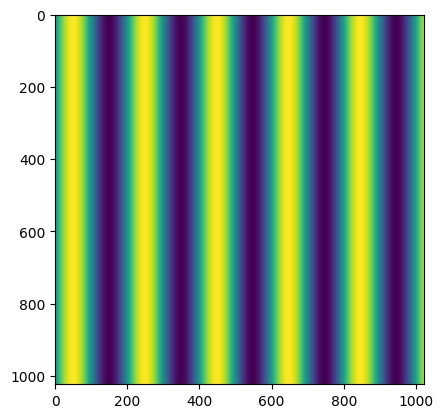

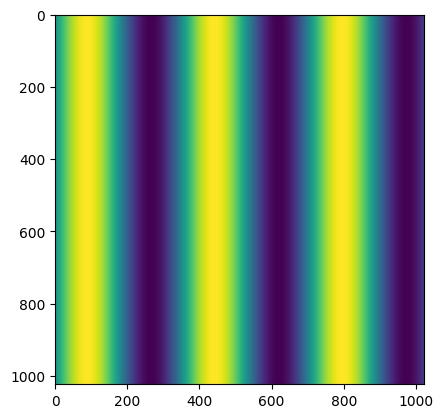

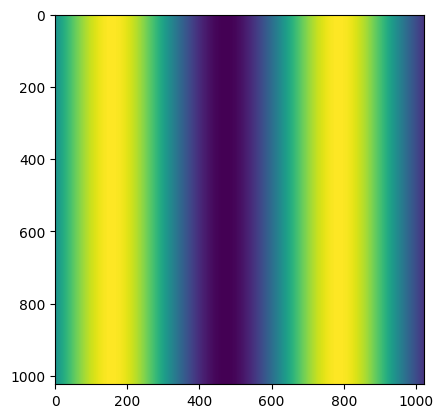

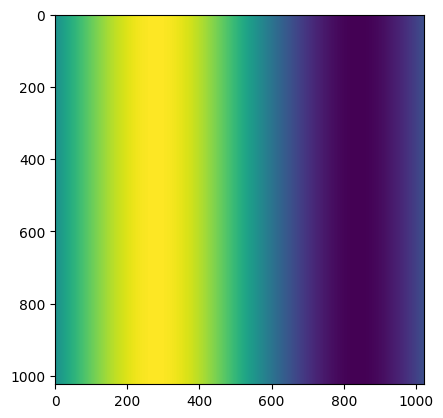

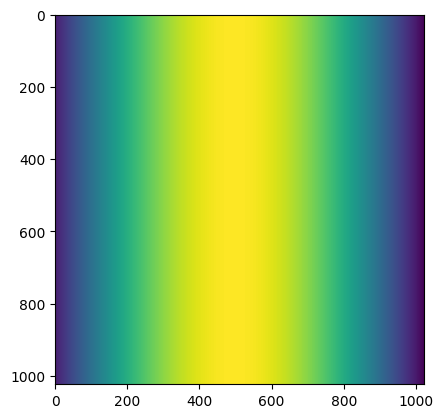

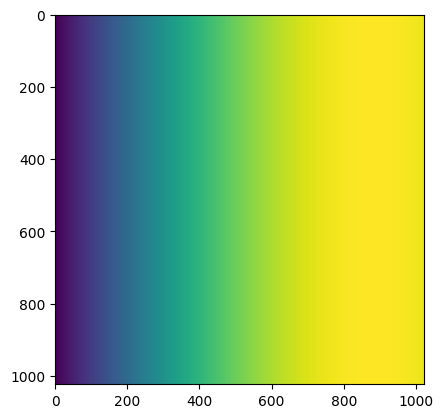

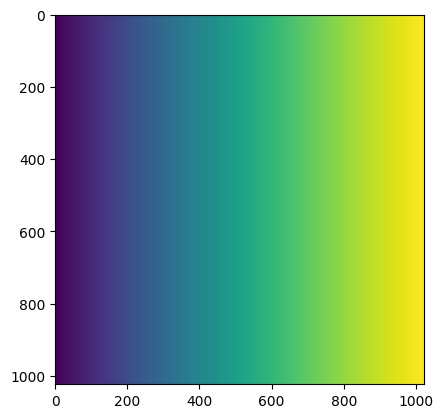

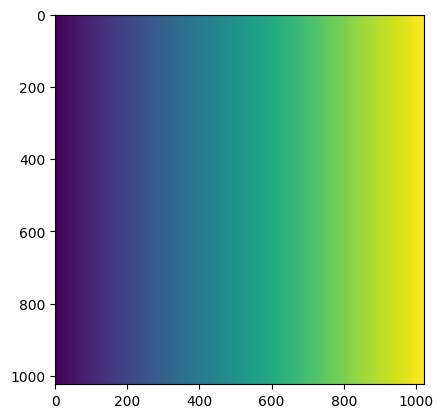

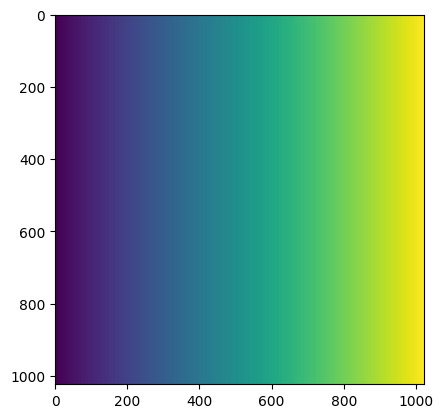

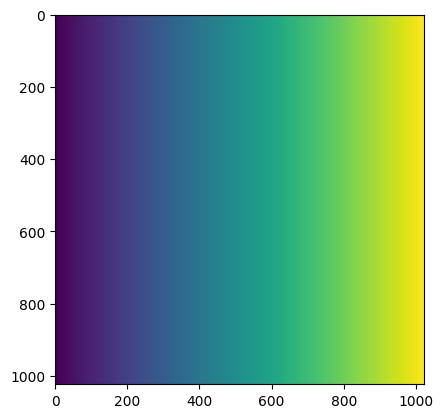

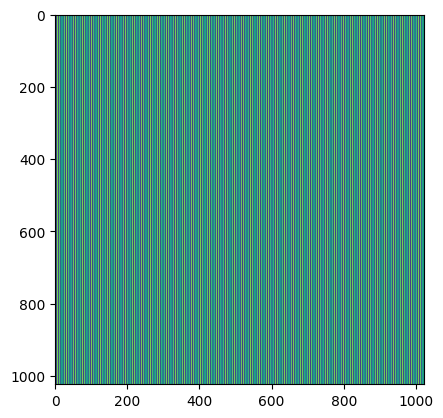

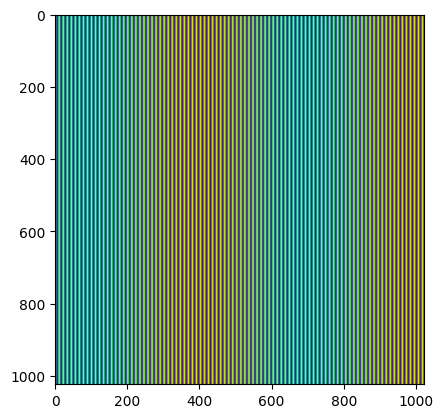

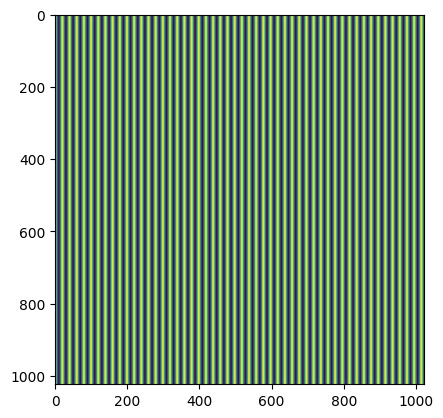

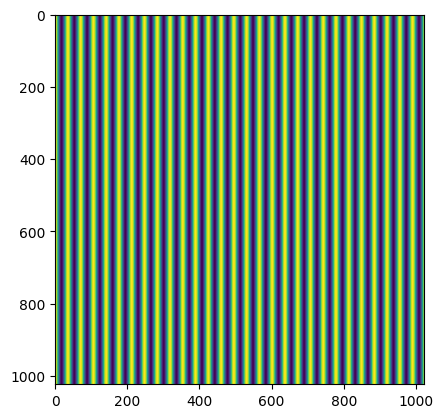

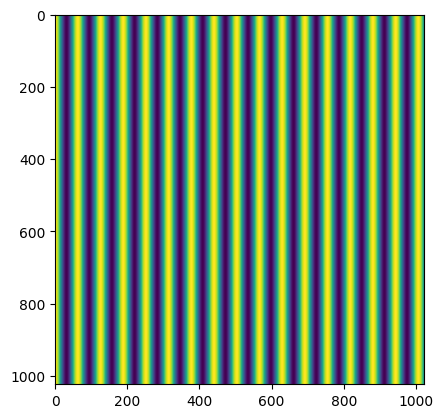

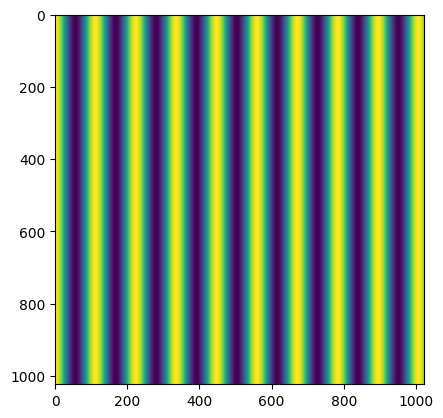

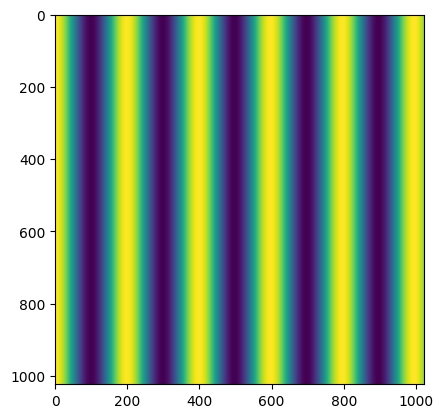

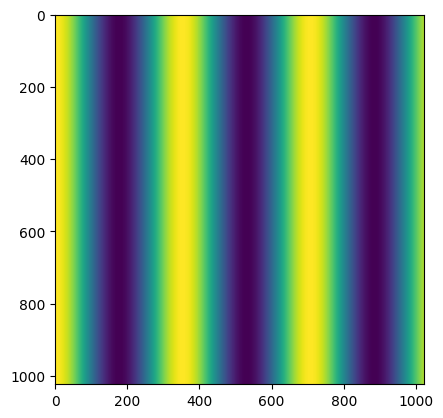

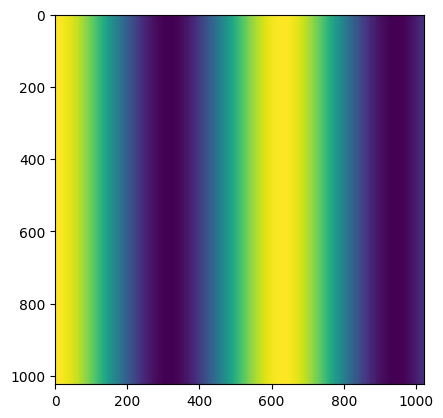

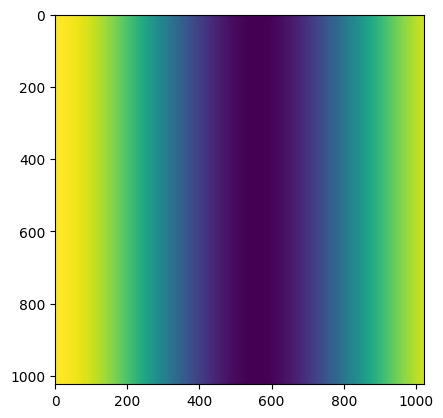

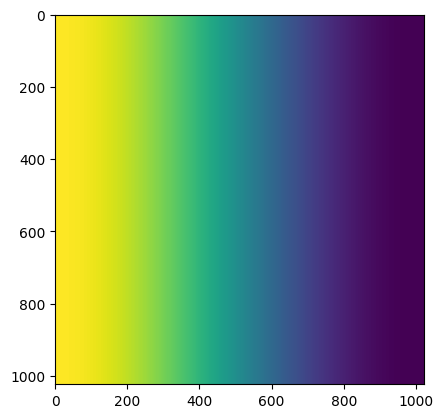

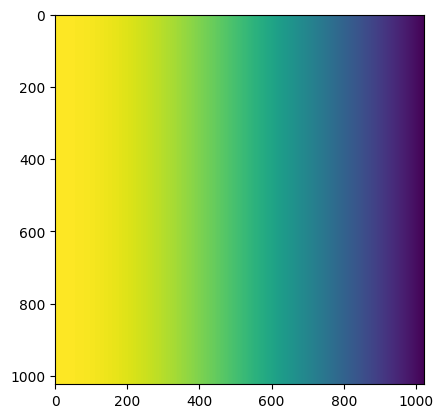

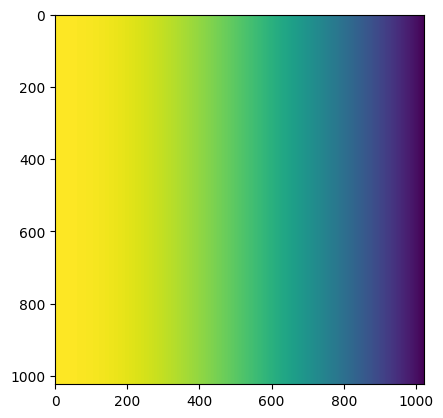

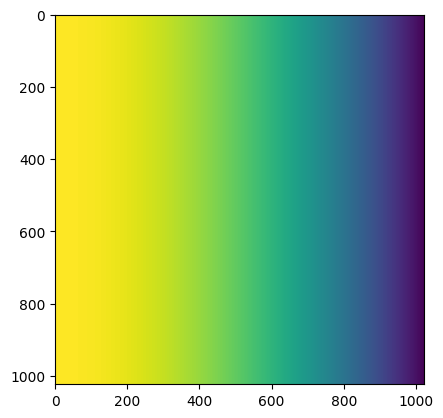

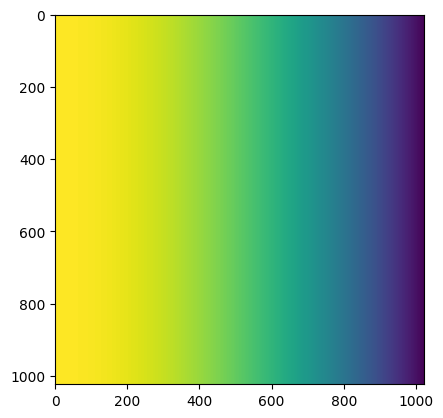

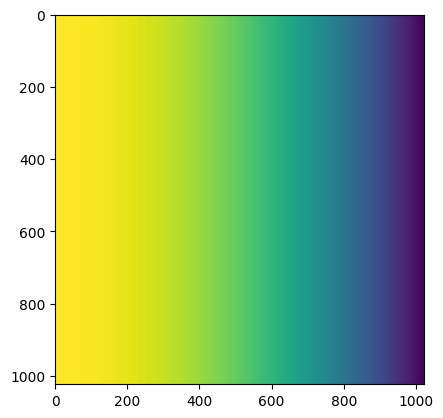

In [1]:
from objVAE import objVAE, fg, bg
import numpy as np
import glob
import tifffile
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import skimage
import torch
broadcaster = bg.SpatialBroadcast(position_dim=64)

embed = broadcaster.sine_embedding(1024, 1024)

for idx in range(embed.shape[0]):
    plt.imshow(embed[idx])
    plt.show()

In [2]:


paths = r"C:\Users\GU\Downloads\BF-C2DL-MuSC\01\*.tif"
paths = glob.glob(paths)

images = [
    tifffile.imread(path) for path in paths[-300:]
]

# background = np.mean(images, axis=0, keepdims=True)

# training_images = images

training_images = np.array(images)
training_images = training_images / 255
training_images = training_images - np.mean(training_images)
training_images = training_images / np.std(training_images, axis=(1, 2), keepdims=True) * 0.5

# high pass filter
# low_freq_signal = np.array([ndi.gaussian_filter(image, 12) for image in training_images])
# training_images = training_images - low_freq_signal

training_images = torch.from_numpy(training_images).float()[:, None]
training_images = training_images[:, :, ::3, ::3]

# # %%
# particles = particle ^ (lambda: np.random.randint(2, 6)) 
# image_pipeline = optics(particles) >> dt.Gaussian(sigma=0.1)

# image_pipeline.update().plot()
# # %%

# # generate a dataset of 1000 images
# images = []
# for i in range(1000):
#     if i % 100 == 0:
#         print(i)
#     images.append(image_pipeline.update()()._value)

In [3]:
import torch

train, test = torch.utils.data.random_split(training_images, [0.85, 0.15])

# create dataloaders
train_loader = torch.utils.data.DataLoader(train, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=8, shuffle=True)

torch.Size([1, 32])


<module 'matplotlib.pyplot' from 'C:\\Users\\GU\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

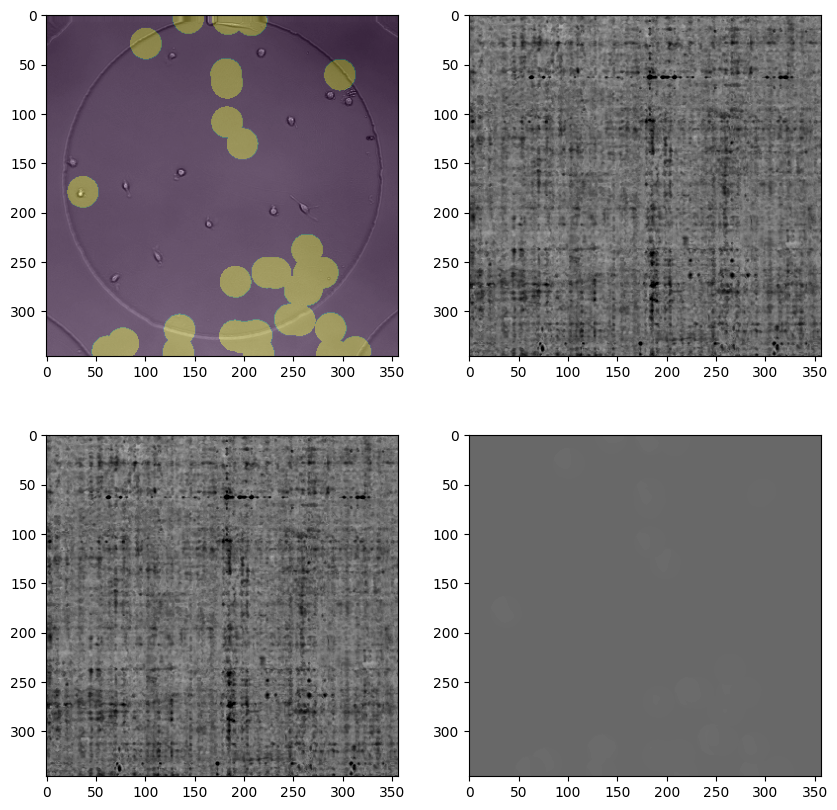

In [7]:
import matplotlib.pyplot as plt

def plot(model, test_loader):
    # forwards pass
    # model.eval()
    x = next(iter(test_loader))
    x = x[:1]
    x = x.to(model.device)

    recon, weightmap, bg, fg, xy, z_bg, kl_bg, kl_fg = model(x)
    print(kl_fg.shape)
    xy = xy.view(1, -1, x.shape[2], x.shape[3])

    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 1)
    plt.imshow(x[0, 0, :, :].detach().cpu().numpy(), cmap="gray")
    plt.imshow((xy[0].sum(0) > 0).detach().cpu().numpy(), alpha=0.3)
    
    plt.subplot(2, 2, 2)
    plt.imshow(
        recon[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    
    plt.subplot(2, 2, 3)
    plt.imshow(
        bg[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    
    plt.subplot(2, 2, 4)
    plt.imshow(
        fg[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )

    return plt

bg_params = {
    'decoder_activation': 'relu',
    'decoder_channels': 60,
    'decoder_norm': 'batch',
    'decoder_depth': 6,
    'encoder_activation': 'relu',
    'encoder_channels': 36,
    'encoder_norm': 'instance',
    'encoder_depth': 5,
    'hidden_dim': 12,
    'position_dim': 128
}

fg_params = {
    'decoder_activation': 'mish',
    'decoder_feature_size': 56,
    'decoder_norm': 'none',
    'decoder_norm_first': True,
    'decoder_num_layers': 4,
    'glimpse_size': 16,
    'latent_dim': 16,
    'position_embedding': 'radial',
    'position_prediction_scale': 1,
    'position_representation_scale': 1,
    'position_embedding_dim': 1,
    'num_entities': 32,
    'encoder_depth': 3,
    'topk_select_method': "max"
}

fg_model = fg.objFG(**fg_params)
bg_model = bg.objBG(in_channels=1,image_size=256, **bg_params)
model = objVAE.objVAE(bg_model=bg_model, fg_model=fg_model, beta=1e-9, learning_rate=5e-4)



torch.Size([1, 32])


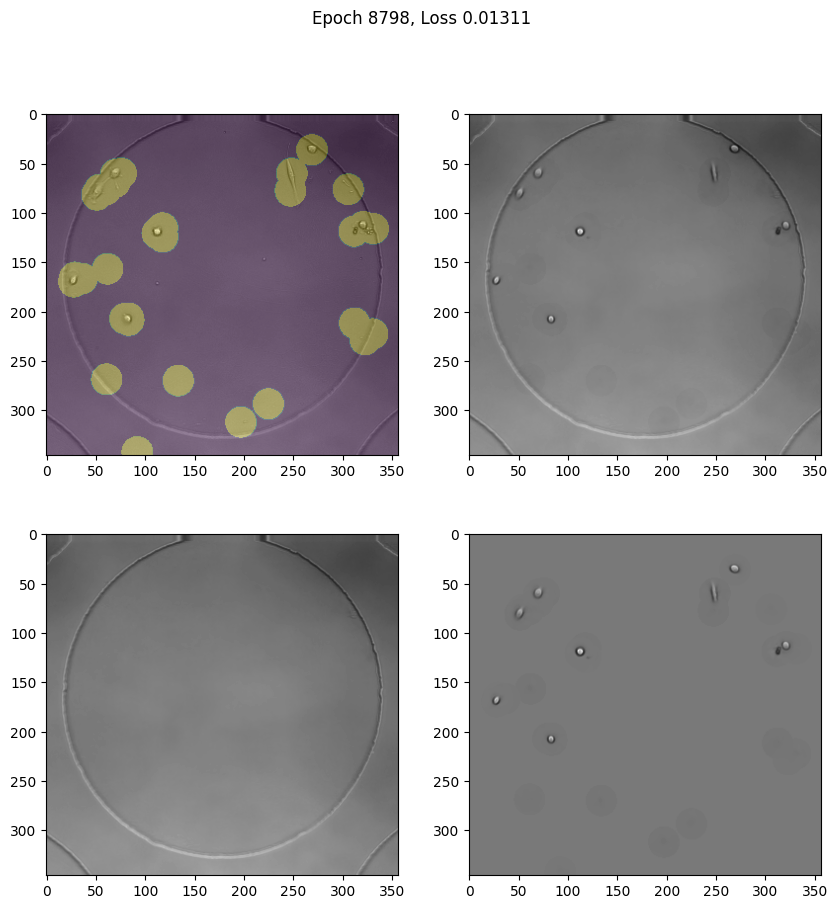

KeyboardInterrupt: 

In [8]:
# anneal beta from 1e-10 to 1e-8 over 150 epochs
import numpy as np
import IPython.display as ipd
import pytorch_lightning as pl
import optuna

epochs = 200000

class PlottingCallback(pl.Callback):


    def on_train_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        ipd.clear_output(wait=True)
        loss = trainer.callback_metrics["loss_epoch"]
        plot(model, train_loader)
        plt.suptitle(f"Epoch {trainer.current_epoch}, Loss {loss:.5f}")

        plt.show()
        


trainer = pl.Trainer(
    gpus=1,
    max_epochs=epochs,
    callbacks=[PlottingCallback()],
    logger=False,
#     check_val_every_n_epoch=9
)

# model.fg_model.topk_select_method = "random"
trainer.fit(model, train_loader)

# evaluate
test_results = trainer.test(model, test_loader)


In [46]:
import torch.nn as nn
import torch.nn.functional as F
def forward(self, x):

        # (B, C, H, W), (B,)
        bg, z_bg, kl_bg = self.bg_model(x)

        # (B, C, H, W), (B, K, hidden_dim), (B, K, 3), (B, K)
        fg, weights, wmap, mask = self.fg_model.fw(self.fg_model, x - bg)

        # loss_dict = self.model.loss_function(x, fg, kl_divergence, mu, logvar)
        # self.log_dict(loss_dict, on_epoch=True, prog_bar=True)
        # return loss_dict["loss"]

        # Treat fg as residual. For microscopy, this is a good assumption.
        # reconstruction = bg + fg
        reconstruction = bg + fg

        return reconstruction, bg, fg, weights, wmap, mask

def fgforward(self, x):
    batch_size = x.shape[0]

    y = self.encoder(x)

    x_mass = torch.abs(x)

    # resize x_mass
    x_mass = F.interpolate(
        x_mass,
        size=(y.shape[2], y.shape[3]),
        mode="bilinear",
        align_corners=True,
    )

    mu = y[:, : self.latent_dim, :, :]
    logvar = y[:, self.latent_dim :, :, :]

    x_range = torch.arange(0, x.shape[2], device=x.device, dtype=torch.float32)
    y_range = torch.arange(0, x.shape[3], device=x.device, dtype=torch.float32)
    x_grid, y_grid = torch.meshgrid(x_range, y_range)

    std = torch.exp(0.5 * logvar)

    parametrization = torch.randn_like(std) * std + mu

    delta_xy_pred = parametrization[:, :2].view(batch_size, 2, -1)
    parametrization = parametrization[:, 2:].view(
        batch_size, self.latent_dim - 2, -1
    )

    # Calculate the KL divergence from the prior of gaussian distribution with mean 0 and std 1
    # to the posterior of the gaussian distribution with mean mu and std std
    # KL divergence is calculated as 0.5 * sum(1 + log(std^2) - mu^2 - std^2)

    kl_divergence = -0.5 * torch.sum(1 + logvar - mu**2 - std**2, dim=1)
    kl_divergence = kl_divergence.view(batch_size, -1)
    # find the i,j indices of the max value num_entities elements in the kl_divergence tensor
    # these indices will be used to select the num_entities most important entities
    if self.topk_select_method == "random":
        indices = self.sample_topk(kl_divergence)
    elif self.topk_select_method == "max":
        indices = self.select_topk(x_mass.view(batch_size, -1))
    else:
        raise NotImplementedError
    # top_kl_divergence, indices = torch.topk(kl_divergence, self.num_entities, dim=1)
    # indices = indices.detach()
    intermediate_feature_map = None

    latents = parametrization[torch.arange(batch_size)[:, None], :, indices]
    pred_delta_xy = delta_xy_pred[torch.arange(batch_size)[:, None], :, indices]

    # repeat latents to match the size of input image
    # (batch_size, num_entities, latent_dim) ->
    # (batch_size, num_entities, x.shape[2] * x.shape[3], latent_dim)
    latents = latents[:, :, None, :].repeat(1, 1, x.shape[2] * x.shape[3], 1)

    # grid channel is a tensor of size (batch_size, latent_dim, 2, x.shape[2], x.shape[3])
    # it contains the x and y coordinates of each pixel in the image
    grid_channel = torch.stack([x_grid, y_grid], dim=-1).view(1, 1, -1, 2)

    # center the grid channel around the coordinates of the entities
    x_coord = indices // y.shape[3]
    y_coord = indices % y.shape[3]

    # add 0.5 to the coordinates to center the grid channel around the coordinates of the entities
    # scale the coordinates to match the size of the input image
    x_coord = (x_coord + 0.5) * x.shape[2] / y.shape[2]
    y_coord = (y_coord + 0.5) * x.shape[3] / y.shape[3]

    xy_coord = torch.stack([x_coord, y_coord], dim=-1).view(batch_size, -1, 1, 2)
    pred_delta_xy = pred_delta_xy.unsqueeze(2)

    grid_channel = (
        grid_channel - xy_coord + pred_delta_xy * self.position_prediction_scale
    ) * self.position_representation_scale

    r_channel = torch.norm(grid_channel, p=2, dim=-1)
    mask = r_channel < (self.glimpse_size * self.position_representation_scale)

    reduced_grid = grid_channel[mask, :]
    reduced_latents = latents[mask, :]

    if self.position_embedding == "none":
        ...
    elif self.position_embedding == "radial":
        r_channel = torch.norm(reduced_grid, p=2, dim=-1, keepdim=True)
        reduced_grid = torch.cat([reduced_grid, r_channel], dim=-1)
    elif self.position_embedding == "sine":
        reduced_grid = self.sine_embedding(reduced_grid)

    # concatenate the grid channel and the latents
    # (batch_size, num_entities, latent_dim + 2, x.shape[2], x.shape[3])
    intermediate_feature_map = torch.cat([reduced_latents, reduced_grid], dim=-1)

    decoded_feature_map = self.decoder_1(intermediate_feature_map)

    pixel_map = self.pixel_decoder(decoded_feature_map)
    weight_map = self.weight_decoder(decoded_feature_map)

    # recreate sparse representation
    pixel_map_tensor = torch.zeros(
        batch_size, self.num_entities, x.shape[2] * x.shape[3], device=x.device
    )
    weight_map_tensor = torch.zeros(
        batch_size, self.num_entities, x.shape[2] * x.shape[3], device=x.device
    )

    pixel_map_tensor[mask] = pixel_map.view(-1)
    weight_map_tensor[mask] = weight_map.view(-1)

    pixel_map = pixel_map_tensor.view(
        batch_size, self.num_entities, 1, x.shape[2], x.shape[3]
    )

    weights = weight_map_tensor.view(
        batch_size, self.num_entities, 1, x.shape[2], x.shape[3]
    )

    weight_map = torch.softmax(weights, dim=1)
    weight_map = weight_map * mask.view(
        batch_size, self.num_entities, 1, x.shape[2], x.shape[3]
    )
    weight_map = weight_map / (torch.sum(weight_map, dim=1, keepdim=True) + 1e-8)

    y = torch.sum(pixel_map * weight_map, dim=1)

    return [y, weights, pixel_map, mask]

model.fw = forward
model.fg_model.fw = fgforward

<module 'matplotlib.pyplot' from 'C:\\Users\\GU\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

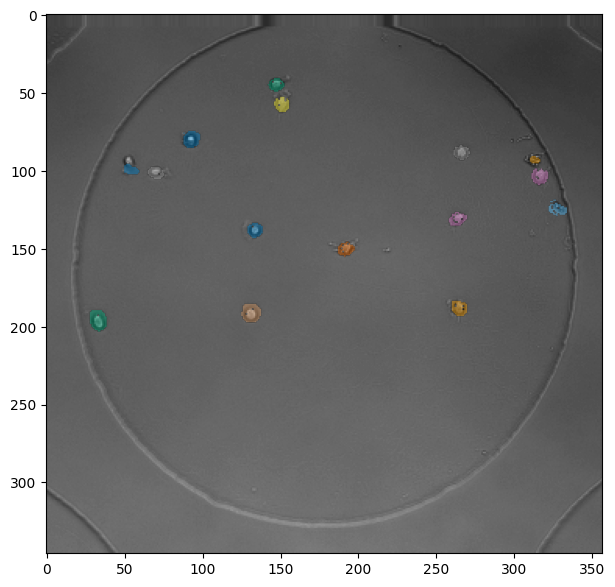

In [62]:
import matplotlib.pyplot as plt

import seaborn as sns

colors = sns.color_palette("colorblind", 32)


def plot(model, test_loader):
    # forwards pass
    # model.eval()
    x = next(iter(test_loader))
    x = x[:1]
    x = x.to(model.device)

    reconstruction, bg, fg, weights, pmap, mask = model.fw(model, x)

    plt.figure(figsize=(16, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(x[0, 0, :, :].detach().cpu().numpy(), cmap="gray")

    segm = torch.abs(pmap) > 0.15

    segmentation_rgba = torch.zeros((x.shape[-2], x.shape[-1], 4)).cpu().numpy()
    

    for idx in range(32):
        s = segm[0, idx, 0].cpu().numpy()
        
        segmentation_rgba[s, 0] = colors[idx][0]
        segmentation_rgba[s, 1] = colors[idx][1]
        segmentation_rgba[s, 2] = colors[idx][2]
        segmentation_rgba[s, 3] = 0.5

    plt.imshow(segmentation_rgba)

    return plt


plot(model, train_loader)


In [36]:
model

objVAE(
  (fg_model): objFG(
    (encoder): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (4): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU()
      (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU()
      (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (decoder_1): Sequential(
      (0): Sequential(
   

In [ ]:
import seaborn as sns
import numpy as np

param_names = best_trial.params.keys()

for key in param_names:
    trials = study.get_trials(deepcopy=False)
    trials = list(filter(lambda t: t.value and t.value < 0.015, trials))
    trials = list(filter(lambda t: tr))
    x = list(map(lambda c: c.params[key], trials))
    y = list(map(lambda c: c.value, trials))
    
    x = np.array(x)
    y = np.array(y)

    # check if x is numerical
    isnumerical = False
    try:
        x = x.astype(np.float)
        isnumerical = True
    except:
        pass

        plt.figure(figsize=(10, 5))
    if not isnumerical:
        # seaborn violin plot
        sns.violinplot(x=x, y=y)
        
    else:
        # seaborn scatter plot
        plt.figure(figsize=(10, 5))
        
    plt.title(key)
    plt.show()

In [ ]:
impo